# Complete Exploratory Data Analysis

This is where your full EDA goes. We look forward to digging deeper into your analysis here. 

Read the [eda_outline.md](eda_outline.md) for more details.  

In [17]:
# ########################### PREPARE DATA ########################### #

from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import polars as pl
import psutil
import seaborn as sns
import numpy as np

import eda_starter_template as eda_basics

# --- Configuration ---
# Robustly determine the project root directory
# Since running from /eda, go up one level to project root
PROJECT_ROOT = Path.cwd().parent
SCRIPT_DIR = PROJECT_ROOT / "eda"
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = SCRIPT_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

btc_df = eda_basics.load_bitcoin_data(COINMETRICS_PATH)
polymarket_dict = eda_basics.load_polymarket_data(POLYMARKET_DIR)


# see initial strategy: https://gemini.google.com/app/08581c93bf8a9ce0 

Loading Bitcoin data from c:\Users\16jac\Repositories\GT-MSA-Spring-2026-Team-13\data\Coin Metrics\coinmetrics_btc.csv...
[Memory] Before loading Bitcoin data: 197.17 MB
[Memory] After loading Bitcoin data: 213.50 MB (Δ 16.33 MB)
Successfully loaded 6221 rows.
Loading Polymarket data from c:\Users\16jac\Repositories\GT-MSA-Spring-2026-Team-13\data\Polymarket...
[Memory] Before loading Polymarket data: 213.52 MB
Loaded 78321 markets.
Loaded 2143181 odds history records.
Loaded 78321 summary records.
[Memory] After loading Polymarket data: 385.16 MB (Δ 171.65 MB)


In [18]:
# ########################### BTC DATASET CHECKS ########################### #

print(btc_df['time'].dtype)
print("Time Range Minimum: ",btc_df['time'].min())
print("Time Range Maximum: ", btc_df['time'].max())

non_positive_price = btc_df.filter(pl.col('PriceUSD') <= 0)
print("Non-positive price entries: ", len(non_positive_price))

btc_df = btc_df.with_columns(
    (pl.col('FlowInExUSD') - pl.col('FlowOutExUSD')).alias('Net Flow USD')
)
print("------------------------------------")
print("Net USD Flow Range: ")
print(btc_df['Net Flow USD'].describe())


Datetime(time_unit='us', time_zone=None)
Time Range Minimum:  2009-01-03 00:00:00
Time Range Maximum:  2026-01-14 00:00:00
Non-positive price entries:  0
------------------------------------
Net USD Flow Range: 
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 5659.0       │
│ null_count ┆ 562.0        │
│ mean       ┆ -5.4841e7    │
│ std        ┆ 3.1780e8     │
│ min        ┆ -5.5125e9    │
│ 25%        ┆ -2.8281e7    │
│ 50%        ┆ -1146.204301 │
│ 75%        ┆ 3.1388e6     │
│ max        ┆ 3.0810e9     │
└────────────┴──────────────┘


In [19]:
# ########################### POLYMARKET DATASET CHECKS ########################### #

print("Polymarket Datasets: ", polymarket_dict.keys())

print("------------------------------------")
print("Markets Dataset Info:")
print("Datatype: ", polymarket_dict['markets']['end_date'].dtype)
print("Time Range Minimum: ",polymarket_dict['markets']['end_date'].min())
print("Time Range Maximum: ", polymarket_dict['markets']['end_date'].max())

market_id_count = polymarket_dict['markets'].get_column('market_id').unique().count()
row_count = len(polymarket_dict['markets'])
print(f"Unique Market IDs: {market_id_count}. Number of Rows: {row_count}")

print("------------------------------------")
print("Odds Dataset Info:")
print("Datatype: ", polymarket_dict['odds']['timestamp'].dtype)
print("Time Range Minimum: ",polymarket_dict['odds']['timestamp'].min())
print("Time Range Maximum: ", polymarket_dict['odds']['timestamp'].max())
print(polymarket_dict['odds']['price'].describe())

print("------------------------------------")
print("Summary Dataset Info:")
print("Datatype: ", polymarket_dict['summary']['first_trade'].dtype)
print("Time Range Minimum: ",polymarket_dict['summary']['first_trade'].min())
print("Time Range Maximum: ", polymarket_dict['summary']['first_trade'].max())

Polymarket Datasets:  dict_keys(['markets', 'odds', 'summary'])
------------------------------------
Markets Dataset Info:
Datatype:  Datetime(time_unit='us', time_zone=None)
Time Range Minimum:  2020-01-01 00:00:00
Time Range Maximum:  2028-11-07 00:00:00
Unique Market IDs: 78321. Number of Rows: 78321
------------------------------------
Odds Dataset Info:
Datatype:  Datetime(time_unit='us', time_zone=None)
Time Range Minimum:  2023-01-24 00:00:12
Time Range Maximum:  2026-01-05 01:02:10
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.143181e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.500006   │
│ std        ┆ 0.390996   │
│ min        ┆ 0.0005     │
│ 25%        ┆ 0.0675     │
│ 50%        ┆ 0.5        │
│ 75%        ┆ 0.9325     │
│ max        ┆ 1.0        │
└────────────┴────────────┘
------------------------------------
Summary Dataset Info:
Datatype:  D

range(-7, 8) [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(0.9999999999999999), np.float64(0.07541982087620416), np.float64(-0.969628232630845), np.float64(-0.6817966598607106), np.float64(-0.8666875724077265), np.float64(-0.6353412367199524), np.float64(0.8253390452447844), np.float64(-0.4297554961206899), np.float64(1.0), np.float64(nan), np.float64(nan), np.float64(nan)]


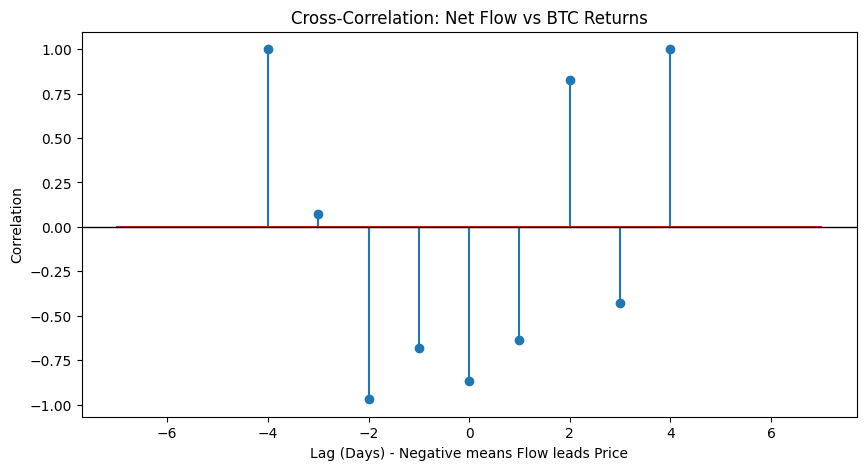

In [24]:
btc_df = btc_df.with_columns(
    ((pl.col('PriceUSD') / pl.col('PriceUSD').shift(1)) - 1).alias('Price Change %')
)

def calculate_cross_corr_polars(df, col1, col2, max_lag=7):
    lags = range(-max_lag, max_lag + 1)
    correlations = []
    
    # Convert to numpy for the correlation calculation
    s1 = df.get_column(col1).to_numpy()
    s2 = df.get_column(col2).to_numpy()
    
    for l in lags:
        if l < 0:
            c = np.corrcoef(s1[-l:], s2[:l])[0, 1]
        elif l > 0:
            c = np.corrcoef(s1[:-l], s2[l:])[0, 1]
        else:
            c = np.corrcoef(s1, s2)[0, 1]
        correlations.append(c)
        
    return lags, correlations



lags, corrs = calculate_cross_corr_polars(btc_df.drop_nulls(), "Net Flow USD", "Price Change %")

print(lags, corrs)
plt.figure(figsize=(10, 5))
plt.stem(lags, corrs)
plt.axhline(0, color='black', linewidth=1)
plt.title("Cross-Correlation: Net Flow vs BTC Returns")
plt.xlabel("Lag (Days) - Negative means Flow leads Price")
plt.ylabel("Correlation")
plt.show()